In [83]:
import random
import json
import pickle
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Embedding, Bidirectional, LSTM, Input, Attention, Flatten, Concatenate  
from keras.optimizers import SGD
import gensim.models
import matplotlib.pyplot as plt

In [84]:
lemmatizer = WordNetLemmatizer()

In [85]:
w2v_model = gensim.models.Word2Vec.load("../data/output/gram.model")

In [86]:

intents = json.loads(open('../data/input/intents.json').read())

In [87]:
words = []
classes = []
documents = []
ignore_letters = ['?', '!', '.', ',']

In [88]:
for intent in intents['intents']:
    for pattern in intent['patterns']:
        word_list = nltk.word_tokenize(pattern)
        words.extend(word_list)
        documents.append((word_list, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [89]:
words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))

classes = sorted(set(classes))

In [90]:
pickle.dump(words, open('../data/output/Attention/words.pkl', 'wb'))
pickle.dump(classes, open('../data/output/Attention/classes.pkl', 'wb'))


In [91]:
training = []
output_empty = [0] * len(classes)

for document in documents:
    bag = []
    word_patterns = document[0]
    word_patterns = [lemmatizer.lemmatize(word.lower()) for word in word_patterns]
    for word in words:
        bag.append(1) if word in word_patterns else bag.append(0)

    output_row = list(output_empty)
    output_row[classes.index(document[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)

In [92]:
# Separate train_x and train_y
train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

In [93]:
input_layer = Input(shape=(len(train_x[0]),))
embedding_layer = Embedding(input_dim=len(words), output_dim=100)(input_layer)
lstm_layer = Bidirectional(LSTM(130, return_sequences=True))(embedding_layer)
attention1 = Attention()([lstm_layer, lstm_layer])
attention1 = Flatten()(attention1)
lstm_layer2 = Bidirectional(LSTM(130, return_sequences=True))(lstm_layer)
attention2 = Attention()([lstm_layer2, lstm_layer2])
attention2 = Flatten()(attention2)
concatenated_attention = Concatenate()([attention1, attention2])
output_layer = Dense(len(train_y[0]), activation='softmax')(concatenated_attention)

model = Model(inputs=[input_layer], outputs=[output_layer])

In [94]:
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])


In [95]:
# Train the model and store the history
history = model.fit(train_x, train_y, epochs=8000, batch_size=16, verbose=1)


Epoch 1/8000
7/7 [==============================] - 5s 79ms/step - loss: 2.3521 - accuracy: 0.1748
Epoch 2/8000
7/7 [==============================] - 1s 78ms/step - loss: 2.1922 - accuracy: 0.1845
Epoch 3/8000
7/7 [==============================] - 1s 80ms/step - loss: 2.1880 - accuracy: 0.2039
Epoch 4/8000
7/7 [==============================] - 1s 83ms/step - loss: 2.1924 - accuracy: 0.1942
Epoch 5/8000
7/7 [==============================] - 1s 79ms/step - loss: 2.1833 - accuracy: 0.1845
Epoch 6/8000
7/7 [==============================] - 1s 97ms/step - loss: 2.1797 - accuracy: 0.2039
Epoch 7/8000
7/7 [==============================] - 1s 93ms/step - loss: 2.1857 - accuracy: 0.1650
Epoch 8/8000
7/7 [==============================] - 1s 88ms/step - loss: 2.1813 - accuracy: 0.1845
Epoch 9/8000
7/7 [==============================] - 1s 91ms/step - loss: 2.1717 - accuracy: 0.2039
Epoch 10/8000
7/7 [==============================] - 1s 86ms/step - loss: 2.1763 - accuracy: 0.1845
Epoch 11/

In [96]:
# Save the model
model.save('data/output/Attention/Rasika.model')

INFO:tensorflow:Assets written to: data/output/Attention/Rasika.model\assets


INFO:tensorflow:Assets written to: data/output/Attention/Rasika.model\assets


In [97]:
# Print "Done"
print("Done")

Done


In [98]:
# Plot training history
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

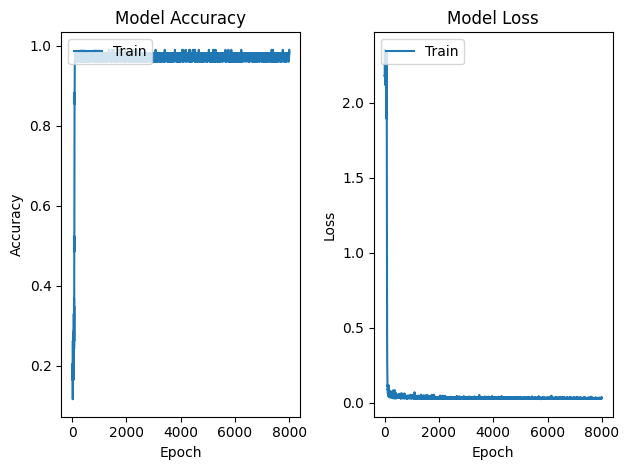

In [99]:
# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train'], loc='upper left')

# Show plots
plt.tight_layout()
plt.show()
